In [1]:
from IPython.display import HTML
HTML(open("../style.css", "r").read())

# Logistic Regression with Automatic Differentiation

In order to use *automatic differentiation* we need to install the library `autograd`.

In [2]:
!conda install -y -c conda-forge autograd

Retrieving notices: done
Channels:
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [3]:
import autograd as ag
import autograd.numpy as np

We define the sigmoid function $S(t) := \large \frac{1}{1 + \exp(-t)}$.

In [4]:
def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))

As we are using NumPy to compute $\exp(t)$, we can feed this function with a `numpy` array to compute the sigmoid function for every element of the array:

In [5]:
sigmoid(np.array([-1.0, 0.0, 1.0]))

array([0.26894142, 0.5       , 0.73105858])

Next, we need to compute the natural logarithm of the sigmoid function, because 
this function is needed to compute the gradient of the *log-likelihood*.  We have 
$$ L(t) := \ln\bigl(S(t)\bigr) = \ln\left(\large\frac{1}{1+\exp(-t)}\right). $$
There is a numerical problem with this formula for very small values of $t$, since for $t < -1000$ the computation of $\ln(t)$ overflows as $\exp(1000)$ can not be represented with a 64 bit floating poingt number.

Therefore, we need an approximation of $L(t)$ for small values of $t$. If $t < -100$ we have:
$$ 
\begin{array}{lcl}
         \ln\left(\large\frac{1}{1+\exp(-t)}\right) 
  & = & -\ln\bigl(1+\exp(-t)\bigr) \\
  & \approx & -\ln\bigl(\exp(-t)\bigr)  \\
  & = & t
\end{array}
$$
Hence $\ln\bigl(S(t)\bigr) \approx t$ for $t < -100$. The following implementation uses this approximation.

In [6]:
def logSigmoid(t):
    if t > -100:
        return -np.log(1.0 + np.exp(-t))
    else:
        return t

Given a feature matrix `X` and a vector `y` of classification outputs, the *log-likelihood function* $\ell\ell(\textbf{w}, \textbf{X}, \textbf{y})$ is mathematically defined as follows:
$$\ell\ell(\mathbf{w}, \mathbf{X},\mathbf{y}) = 
 \sum\limits_{i=1}^N \ln\Bigl(S\bigl(y_i \cdot(\mathbf{x}_i^\top \cdot \mathbf{w})\bigr)\Bigr) =
 \sum\limits_{i=1}^N L\bigl(y_i \cdot(\mathbf{x}_i^\top \cdot \mathbf{w})\bigr)
$$
The value of the *log-likelihood function* is interpreted as the logarithm of the probability that our model of the classifier predicts the observed values $y_i$ when the features are given by the vector $\textbf{x}_i$ for all $i\in\{1,\cdots,N\}$.

The arguments $\textbf{w}$, $\textbf{X}$, and $\textbf{y}$, of the function `ll` are interpreted as follows:
* $\textbf{w}$ is the weight vector.
* $\textbf{X}$ is the feature matrix, $\textbf{X}[i]$ is the $i$-th feature vector, i.e we have
  $\textbf{X}[i] = \textbf{x}_i^\top$.
         
  Furthermore, it is assumed that $\textbf{X}[i][0]$ is 1.0 for all $i$.  
  Hence we have a feature that is constant for all examples.
* $\textbf{y}$ is the output vector, $\textbf{y}[i] \in \{-1,+1\}$ for all $i$.

In [7]:
def ll(w, X, y):   
    return np.sum([logSigmoid(y[i] * (X[i] @ w)) for i in range(len(X))])

The function $\mathtt{gradLL}(\mathbf{x}, \mathbf{y}, \mathbf{w})$ computes the gradient of
the log-likelihood using `autograd` instead of using the formula
$$ \frac{\partial\quad}{\partial\, w_j}\ell\ell(\mathbf{X},\mathbf{y},\mathbf{w}) =
   \sum\limits_{i=1}^N y_i \cdot x_{i,j} \cdot  S(-y_i \cdot \mathbf{x}_i \cdot \mathbf{w}).
$$
The different components of this gradient are combined into a vector.
The arguments are the same as the arguments to the function $\ell\ell$ that computes the log-likelihood, i.e.
* $\textbf{X}$ is the feature matrix, $\textbf{X}[i]$ is the transpose of $i$-th feature vector.
* $\textbf{y}$ is the output vector, $\textbf{y}[i] \in \{-1,+1\}$ for all $i$.
* $\textbf{w}$ is the weight vector.

In [8]:
gradLL = ag.grad(ll)

The data we want to investigate is stored in the file `'exam.csv'`.  The first column of this file is an integer from the set $\{0,1\}$.  The number is $0$ if the corresponding student has failed the exam and is $1$ otherwise.  The second column is a floating point number that lists the number of hours that the student has studied for the given exam.

In [9]:
import csv

The file `exam.csv` contains fictional data about an exam. The first column contains the number `0` if the student has failed the exam and `1` otherwise.  The second column contains the number of hours the student has studied on average every week.

In [10]:
!cat exam.csv || type exam.csv

Pass,Hours
0,0.50
0,0.75
0,1.00
0,1.25
0,1.50
0,1.75
1,1.75
0,2.00
1,2.25
0,2.50
1,2.75
0,3.00
1,3.25
0,3.50
1,4.00
1,4.25
1,4.50
1,4.75
1,5.00
1,5.50


In [11]:
with open('exam.csv') as file:
    reader = csv.reader(file, delimiter=',')
    count  = 0  # line count
    Pass   = []
    Hours  = []
    for row in reader:
        if count != 0:  # skip header
            Pass .append(float(row[0]))
            Hours.append(float(row[1]))
        count += 1

To proceed, we will plot the data points.  To this end we transform the lists `Pass` and `Hours` into numpy arrays.

In [12]:
y = np.array(Pass)
x = np.array(Hours)

In [13]:
import matplotlib.pyplot as plt
import seaborn           as sns

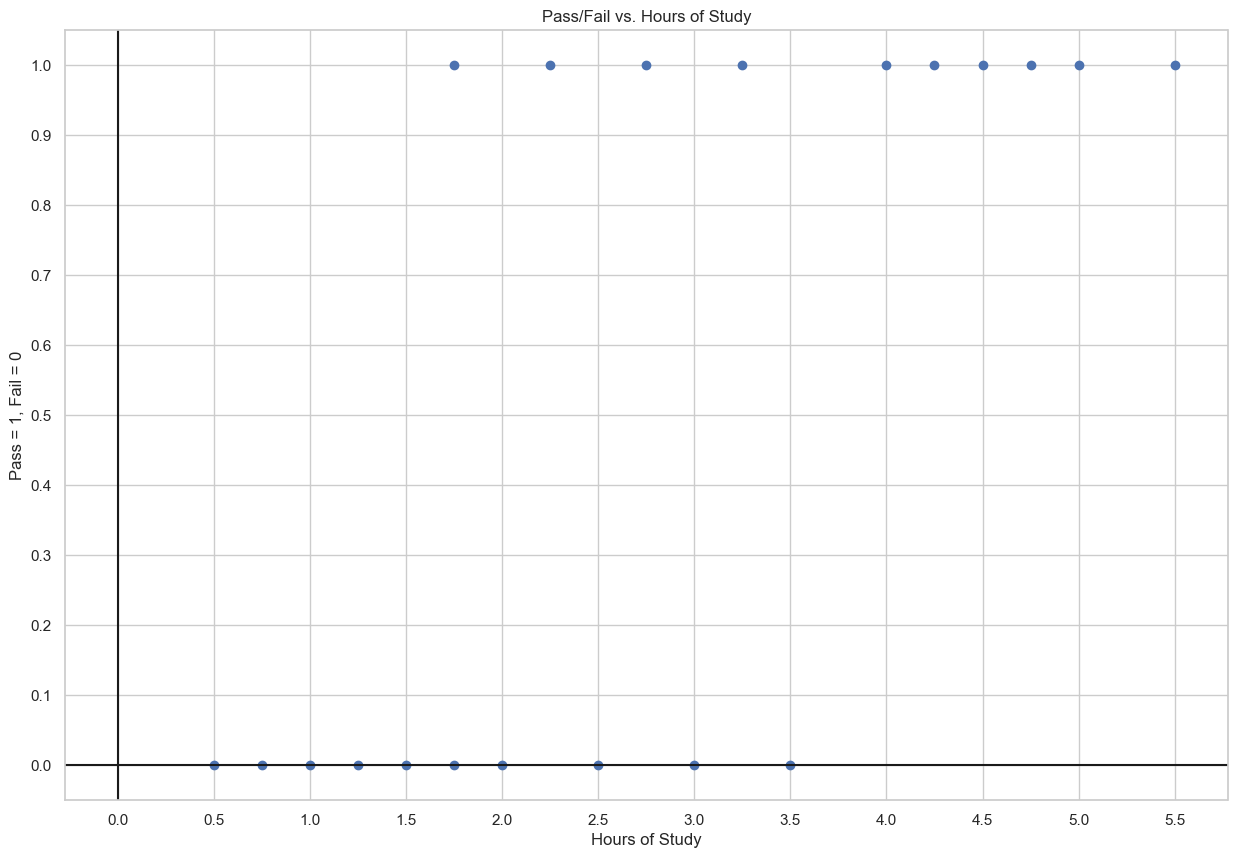

In [14]:
plt.figure(figsize=(15, 10))
sns.set(style='whitegrid')
plt.title('Pass/Fail vs. Hours of Study')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('Hours of Study')
plt.ylabel('Pass = 1, Fail = 0')
plt.xticks(np.arange(0.0, 6.0, step=0.5))
plt.yticks(np.arange(-0.0, 1.1, step=0.1))
plt.scatter(x, y, color='b')

The number of students is stored in the variable `n`.

In [15]:
n = len(y)
n

20

We have to turn the vector `x` into the feature matrix `X`.

In [16]:
x.shape

(20,)

In [17]:
X = np.reshape(x, (n, 1))
X

array([[0.5 ],
       [0.75],
       [1.  ],
       [1.25],
       [1.5 ],
       [1.75],
       [1.75],
       [2.  ],
       [2.25],
       [2.5 ],
       [2.75],
       [3.  ],
       [3.25],
       [3.5 ],
       [4.  ],
       [4.25],
       [4.5 ],
       [4.75],
       [5.  ],
       [5.5 ]])

We append the number $1.0$ to every row of `X`. `axis=1` specifies that the ones are appended to each column.  If we had specified `axis=0` instead, the number of rows would have doubled.

In [18]:
X = np.append(X, np.ones((n, 1)), axis=1)
X

array([[0.5 , 1.  ],
       [0.75, 1.  ],
       [1.  , 1.  ],
       [1.25, 1.  ],
       [1.5 , 1.  ],
       [1.75, 1.  ],
       [1.75, 1.  ],
       [2.  , 1.  ],
       [2.25, 1.  ],
       [2.5 , 1.  ],
       [2.75, 1.  ],
       [3.  , 1.  ],
       [3.25, 1.  ],
       [3.5 , 1.  ],
       [4.  , 1.  ],
       [4.25, 1.  ],
       [4.5 , 1.  ],
       [4.75, 1.  ],
       [5.  , 1.  ],
       [5.5 , 1.  ]])

Currently, the entries in the vector `y` are either $0$ or $1$.  These values need to be transformed to $-1$ and $+1$. 

In [19]:
y = 2 * y - 1
y

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.])

As we have no real clue about the weights, we set them to $0$ initially.

In [20]:
import gradient_ascent

In [21]:
start   = np.array([0.0, 0.0])
eps     = 10 ** -8
f       = lambda w: ll(w, X, y)
gradF   = lambda w: gradLL(w, X, y)
w, _, _ = gradient_ascent.findMaximum(f, gradF, start, eps)
beta    = w[1]
gamma   = w[0]
print(f'model: P(pass|hours) = S({beta} + {gamma} * hours)')

model: P(pass|hours) = S(-4.074646895934354 + 1.5033787070591218 * hours)


As the module `seaborn` uses some deprecated features, I silence the corresponding warnings.

In [22]:
import warnings

Let us plot the model together with the data.

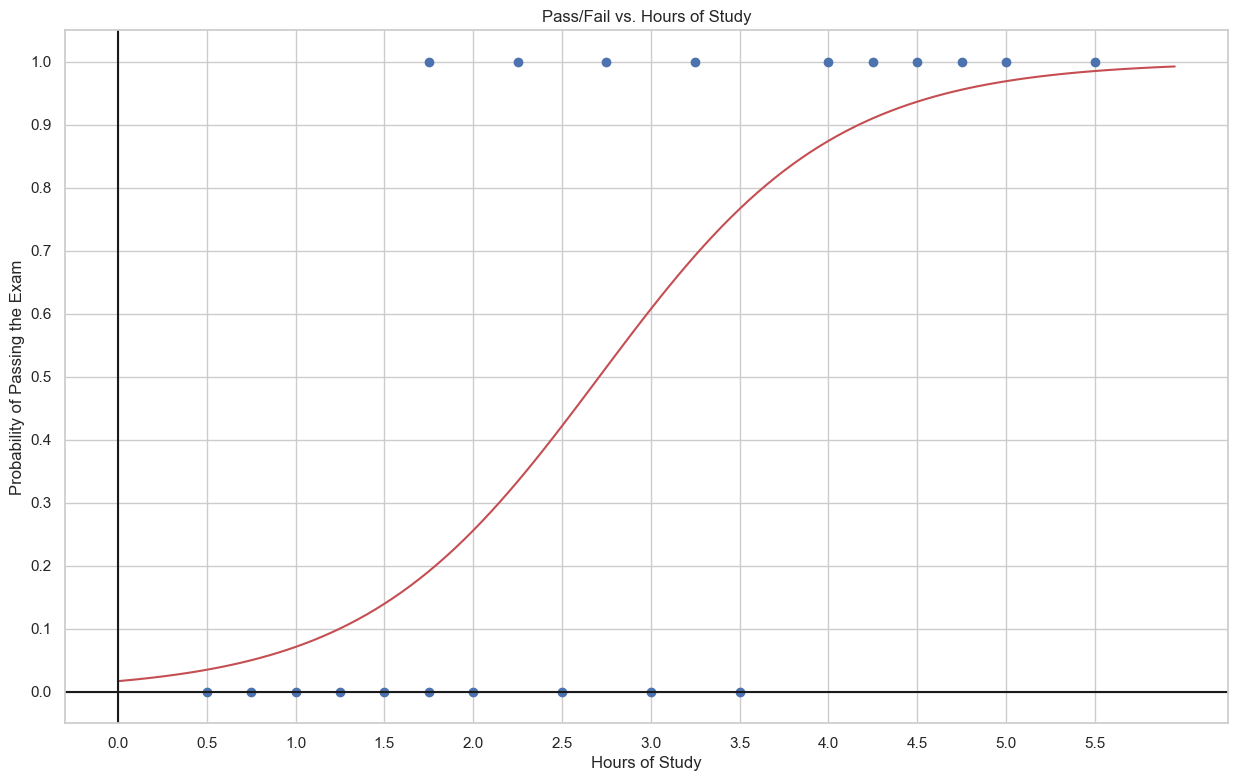

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plt.figure(figsize=(15, 9))
    sns.set_style('whitegrid')
    plt.title('Pass/Fail vs. Hours of Study')
    H = np.arange(0.0, 6.0, 0.05)
    P = sigmoid(beta + gamma * H)
    sns.lineplot(x=H, y=P, color='r')
    plt.axvline(x=0.0, c='k')
    plt.axhline(y=0.0, c='k')
    plt.xlabel('Hours of Study')
    plt.ylabel('Probability of Passing the Exam')
    plt.xticks(np.arange(0.0, 6.0, step=0.5))
    plt.yticks(np.arange(-0.0, 1.01, step=0.1))
    plt.scatter(x, (y + 1) / 2, color='b')
    plt.savefig('exam-probability.pdf')